In [20]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU, Bidirectional, Input, Activation, BatchNormalization,MaxPooling2D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn.tcn import TCN,compiled_tcn,tcn_full_summary
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard


In [21]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [22]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [23]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [24]:
ticker='TSLA'

In [25]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [26]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [27]:
dates = pd.to_datetime(df['Date'])

In [28]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [29]:
df_for_training = df[cols].astype(float)

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [31]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [32]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [33]:
n_future = 1  # Number of days we want to predict into the future
n_past = 7  # Number of past days we want to use to predict the future

In [34]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [35]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [36]:
import math as m
def n_layers(ks):
    n=m.ceil(m.log2((((n_past-1)*(2-1))/(ks-1))+1))
    return n

In [37]:
def build_model(input_shape, output_shape):
    ks=2
    model=Sequential()
    model.add(
     TCN(
        input_shape=input_shape,
        kernel_size=ks,
        return_sequences=True,
        #dilations=[2**i for i in range(0,n_layers(ks))],
        activation='relu',
        nb_filters=8,
        padding='causal',
        kernel_initializer='he_normal',
        use_skip_connections=True,
     )   
    )
    model.add(GlobalAveragePooling1D())
    model.add(Dense(output_shape))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=10)

(283, 7, 17)
Epoch 1/1000


9/9 [==============================] - 2s 40ms/step - loss: 6.1841 - val_loss: 4.8384
Epoch 2/1000
9/9 [==============================] - 0s 8ms/step - loss: 5.3538 - val_loss: 4.2077
Epoch 3/1000
9/9 [==============================] - 0s 8ms/step - loss: 4.6121 - val_loss: 3.6405
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 3.9531 - val_loss: 3.1380
Epoch 5/1000
9/9 [==============================] - 0s 9ms/step - loss: 3.3733 - val_loss: 2.6965
Epoch 6/1000
9/9 [==============================] - 0s 9ms/step - loss: 2.8707 - val_loss: 2.3156
Epoch 7/1000
9/9 [==============================] - 0s 8ms/step - loss: 2.4415 - val_loss: 1.9895
Epoch 8/1000
9/9 [==============================] - 0s 9ms/step - loss: 2.0743 - val_loss: 1.7090
Epoch 9/1000
9/9 [==============================] - 0s 8ms/step - loss: 1.7599 - val_loss: 1.4665
Epoch 10/1000
9/9 [==============================] - 0s 8ms/step - loss: 1.4908 - val_loss: 1.2571
Epoch 11/1000
9/9 [============

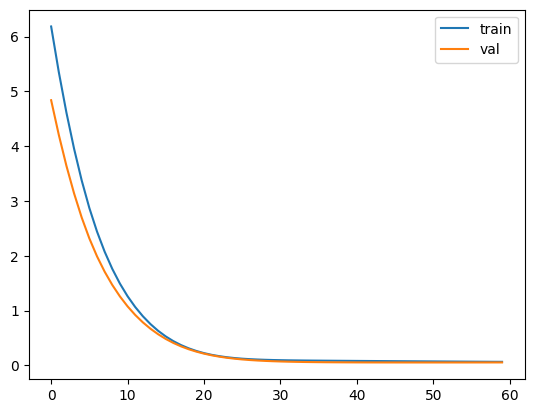

10/10 [==============================] - 0s 2ms/step
mae: 10.245775366396394


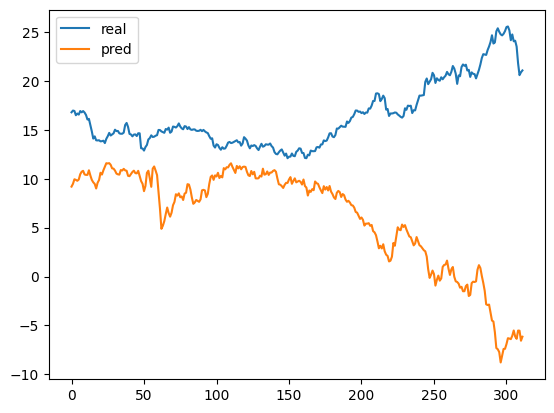

(564, 7, 17)
Epoch 1/1000
18/18 [==============================] - 2s 23ms/step - loss: 4.1197 - val_loss: 13.6606
Epoch 2/1000
18/18 [==============================] - 0s 8ms/step - loss: 3.1282 - val_loss: 10.9513
Epoch 3/1000
18/18 [==============================] - 0s 7ms/step - loss: 2.3767 - val_loss: 8.6978
Epoch 4/1000
18/18 [==============================] - 0s 9ms/step - loss: 1.7959 - val_loss: 6.8887
Epoch 5/1000
18/18 [==============================] - 0s 7ms/step - loss: 1.3483 - val_loss: 5.4679
Epoch 6/1000
18/18 [==============================] - 0s 7ms/step - loss: 1.0034 - val_loss: 4.3493
Epoch 7/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.7382 - val_loss: 3.4710
Epoch 8/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.5369 - val_loss: 2.7810
Epoch 9/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.3878 - val_loss: 2.2462
Epoch 10/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.2796 - 

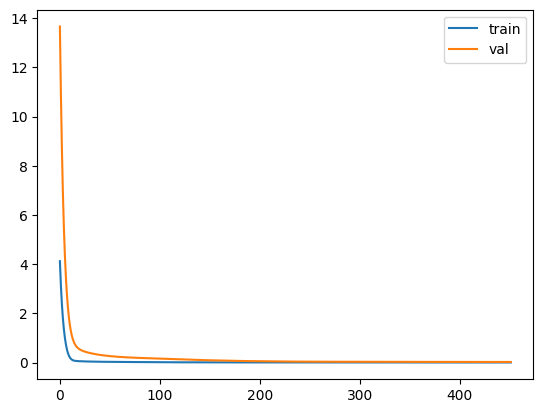

10/10 [==============================] - 0s 2ms/step
mae: 9.162806336194063


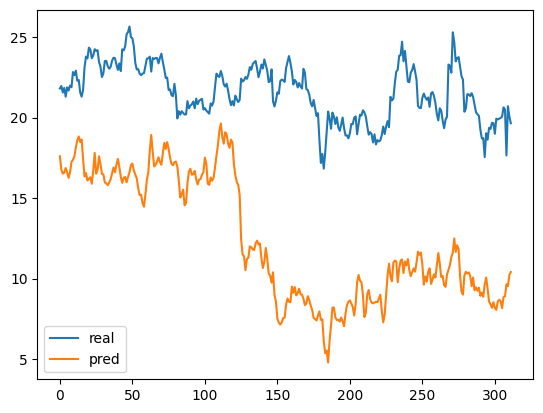

(845, 7, 17)
Epoch 1/1000
27/27 [==============================] - 2s 13ms/step - loss: 8.1061 - val_loss: 13.5181
Epoch 2/1000
27/27 [==============================] - 0s 6ms/step - loss: 6.0497 - val_loss: 10.7747
Epoch 3/1000
27/27 [==============================] - 0s 7ms/step - loss: 4.7283 - val_loss: 8.8426
Epoch 4/1000
27/27 [==============================] - 0s 6ms/step - loss: 3.8258 - val_loss: 7.4364
Epoch 5/1000
27/27 [==============================] - 0s 6ms/step - loss: 3.1718 - val_loss: 6.3719
Epoch 6/1000
27/27 [==============================] - 0s 6ms/step - loss: 2.6804 - val_loss: 5.5283
Epoch 7/1000
27/27 [==============================] - 0s 6ms/step - loss: 2.2988 - val_loss: 4.8421
Epoch 8/1000
27/27 [==============================] - 0s 6ms/step - loss: 1.9942 - val_loss: 4.2670
Epoch 9/1000
27/27 [==============================] - 0s 6ms/step - loss: 1.7439 - val_loss: 3.7730
Epoch 10/1000
27/27 [==============================] - 0s 6ms/step - loss: 1.5344 - 

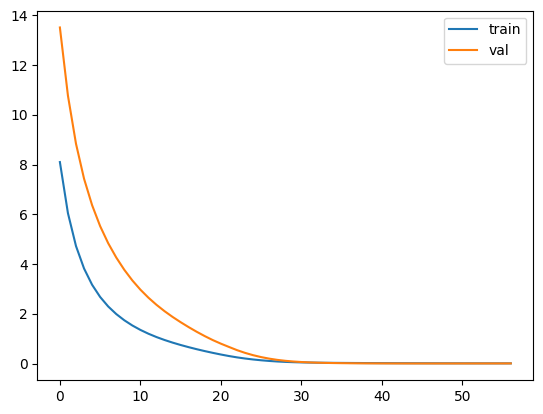

10/10 [==============================] - 0s 2ms/step
mae: 3.8085022806940323


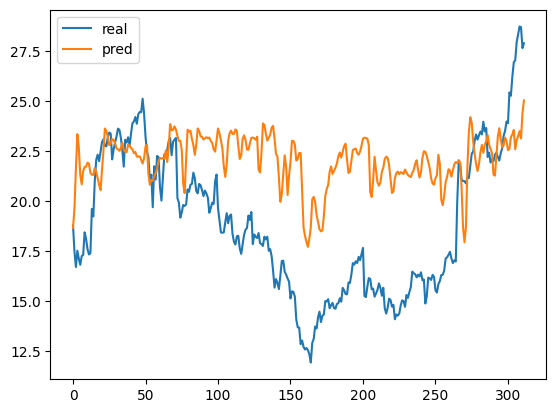

In [38]:
tscv = TimeSeriesSplit(n_splits=3)
maes=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.9)  # Adjust the validation split percentage as needed
    X_train, x_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    print(X_train.shape)

    model=build_model(input_shape=(X_train.shape[1],X_train.shape[2]),output_shape=y_train.shape[1])
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    mae=np.mean(np.abs(pred-y_test))
    maes.append(mae)
    print('mae:',mae)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()



In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_5 (TCN)                 (None, 7, 8)              1920      
                                                                 
 global_average_pooling1d_5  (None, 8)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1929 (7.54 KB)
Trainable params: 1929 (7.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


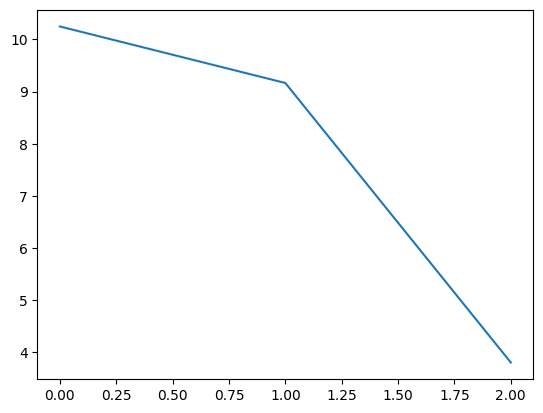

In [40]:
plt.plot(maes)
plt.show()

In [41]:
avg_mae=np.mean(maes)
print('avg_mae:',avg_mae)

avg_mae: 7.739027994428163
